In [1]:
# Install dependencies
!pip install torch-geometric
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.13.1+cu116.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.13.1+cu116.html
!pip install seaborn



[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html



[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html



[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import dependencies, check versions
import torch_geometric
import pandas as pd
import torch
import os
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
# And some typing for code completion
from typing import Dict, List, Tuple, Union, Optional

print(torch.__version__)
print(torch_geometric.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Running on", device)

"""
Should be:
1.13.1
2.2.0
"""
pass


1.13.1+cpu
2.2.0
Running on cpu


In [3]:
# Dataset location
os.environ['DATASET_PATH'] = r'D:/Documents/FAKS/3. LETNIK/MLG/project-final/elliptic_bitcoin_dataset' # Uncomment this to add own path
is_running_from_local = 'DATASET_PATH' in os.environ
if is_running_from_local:
    print('DATA_PATH: ', os.environ['DATASET_PATH'])
    DATASET_PATH = os.environ['DATASET_PATH']
else:
    from google.colab import drive
    drive.mount('/content/drive')  # Check: !ls drive/MyDrive/
    DATASET_PATH = 'drive/MyDrive/elliptic_bitcoin_dataset/'
    print("Reading from Google Colab")
    print('DATA_PATH: ', DATASET_PATH)


DATA_PATH:  D:/Documents/FAKS/3. LETNIK/MLG/project-final/elliptic_bitcoin_dataset


In [4]:
# Reading data to DataFrames
classes = pd.read_csv(
    f"{DATASET_PATH}/elliptic_txs_classes.csv", index_col="txId")
edgelist = pd.read_csv(
    f"{DATASET_PATH}/elliptic_txs_edgelist.csv")

# index is on top level timestamp, second level txId
features = pd.read_csv(
    f"{DATASET_PATH}/elliptic_txs_features.csv", header=None, index_col=[1, 0])
features.index.names = ['timestamp', 'txId']

# That way, features are sorted by timestamp, as sample of first 5 columns shows:
display(features.loc[:, :5])

# TODO! Feature statistic/normalization

2         3         4          5
timestamp txId                                              
1         230425980 -0.171469 -0.184668 -1.201369  -0.121970
          5530458   -0.171484 -0.184668 -1.201369  -0.121970
          232022460 -0.172107 -0.184668 -1.201369  -0.121970
          232438397  0.163054  1.963790 -0.646376  12.409294
          230460314  1.011523 -0.081127 -1.201369   1.153668
...                       ...       ...       ...        ...
49        173077460 -0.145771 -0.163752  0.463609  -0.121970
          158577750 -0.165920 -0.123607  1.018602  -0.121970
          158375402 -0.172014 -0.078182  1.018602   0.028105
          158654197 -0.172842 -0.176622  1.018602  -0.121970
          157597225 -0.012037 -0.132276  0.463609  -0.121970

[203769 rows x 4 columns]

In [5]:
# Defining target classes
# Initial graph should be directed
directed_graph = nx.from_pandas_edgelist(
    edgelist, source='txId1', target='txId2', create_using=nx.DiGraph())
print(f"{nx.is_directed(directed_graph)=}")


ID_ILLICIT = 0  # Fraud
ID_LICIT = 1  # Legiet
ID_UNLABELED = 2 # Unknown

classes['y'] = classes['class'].replace(
    {'unknown': ID_UNLABELED, '1': ID_ILLICIT, '2': ID_LICIT})
class_mapping = classes[['y']].to_dict("dict")['y']

keys = features.index.get_level_values(1)
rows = torch.tensor(features.values, dtype=torch.double, device=device)
feature_mapping = dict(zip(keys, rows))


nx.is_directed(directed_graph)=True


In [6]:
# Subgraph splitting
timestamps = features.index.get_level_values(
    0).unique().sort_values().to_list()
ts_Tid_df = features.index.to_frame(index=False)
dataset = []
for ts in timestamps:
    # Get all txIds for a given timestamp
    sub_graph_idx = ts_Tid_df[ts_Tid_df.timestamp == ts].txId.to_list()
    # Create subgraph from the original graph
    s = directed_graph.subgraph(sub_graph_idx)
    nx.set_node_attributes(s, class_mapping, "y")
    nx.set_node_attributes(s, feature_mapping, "x")

    dataset.append(s)

# Takes ~20sec to run


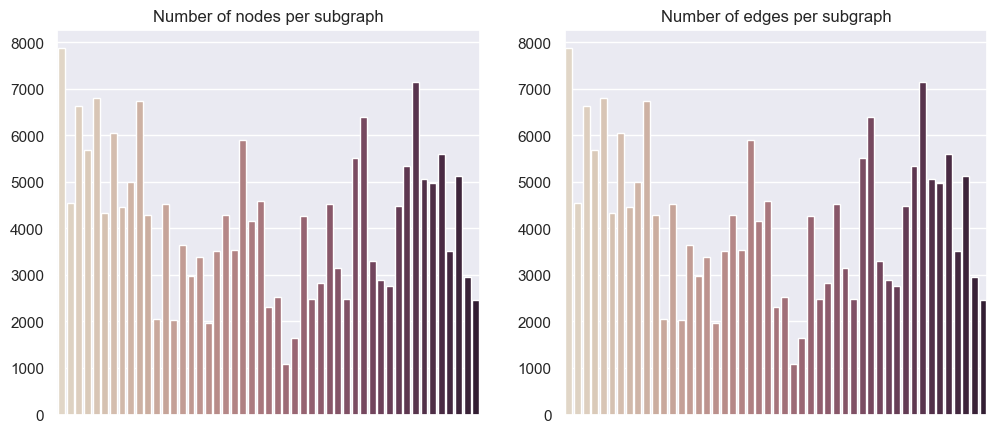

In [93]:
import seaborn as sns
sns.set_theme()

# Vertex/Edge count
node_dict = {i: len(subgraph.nodes) for i, subgraph in enumerate(dataset)}
edge_dict = {i: len(subgraph.edges) for i, subgraph in enumerate(dataset)}

# using seaborn implementation
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12,5))
node_indices = list(node_dict.keys())
node_count = list(node_dict.values())
nodes_graph = sns.barplot(ax=axes[0], x=node_indices, y=node_count, palette="ch:.25")
nodes_graph.set(xticklabels=[])
nodes_graph.set_title("Number of nodes per subgraph")

edge_indices = list(edge_dict.keys())
edge_count = list(edge_dict.values())
edge_graph = sns.barplot(ax=axes[1], x=node_indices, y=node_count, palette="ch:.25")
edge_graph.set(xticklabels=[])
_x = edge_graph.set_title("Number of edges per subgraph")


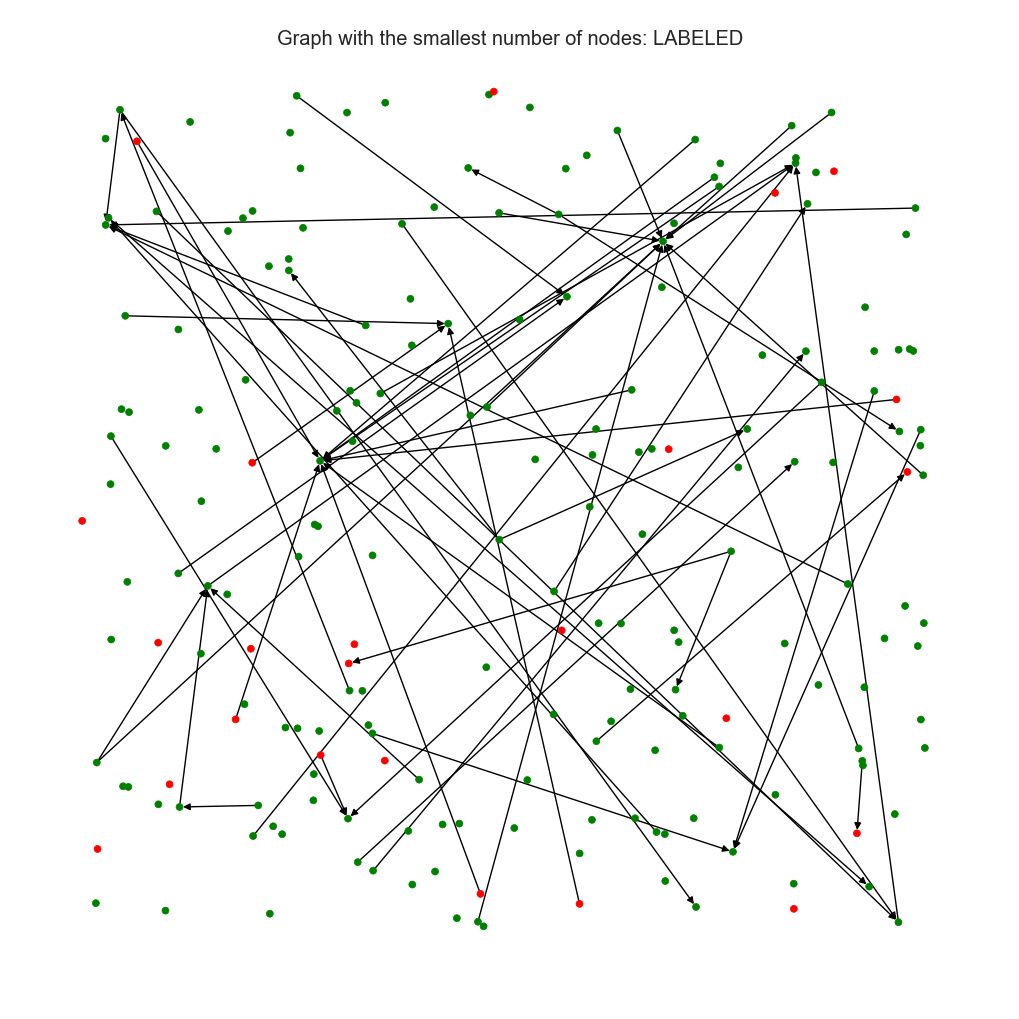

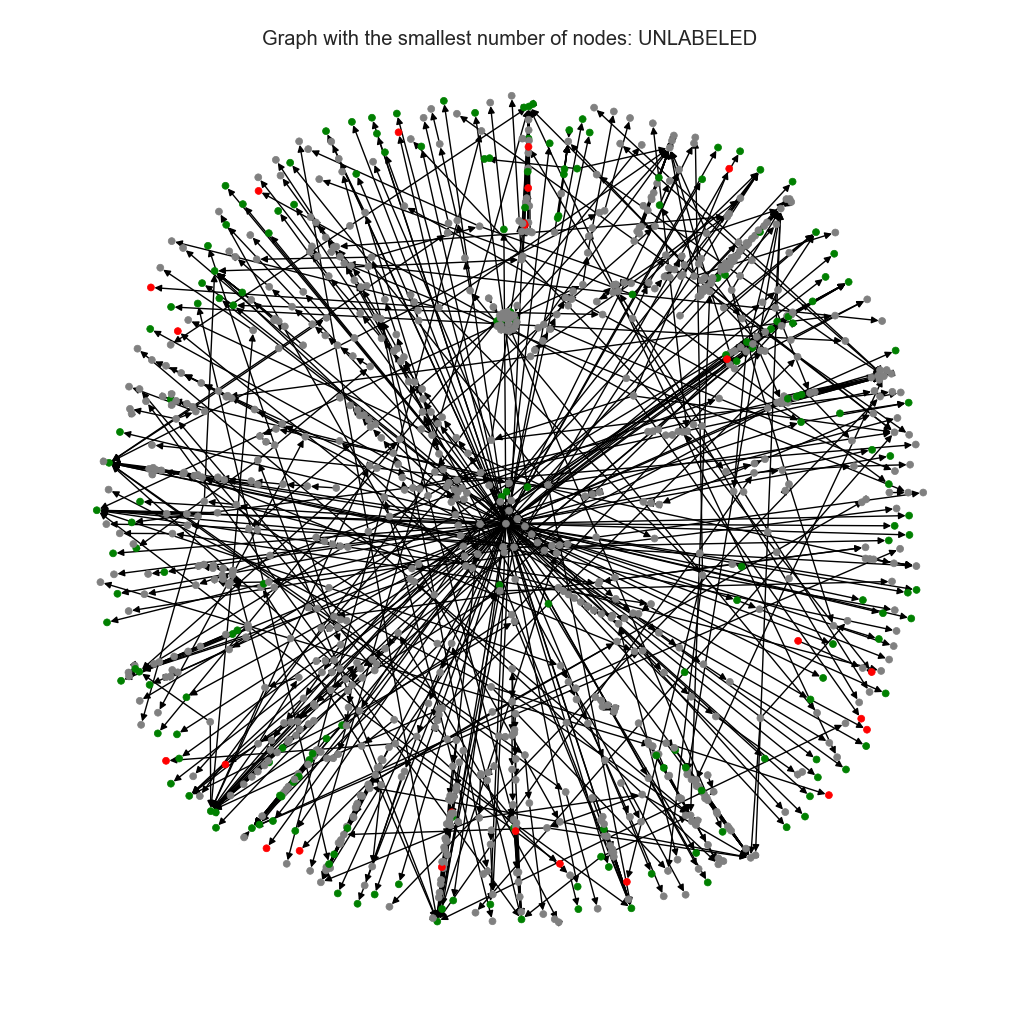

In [118]:
# Displaying the smallest subgraph
min_idx = min(node_dict, key=node_dict.get)
smallest_subgraph = dataset[min_idx]
labeled_nodes = [x for x,y in smallest_subgraph.nodes(data=True) if y['y']!=ID_UNLABELED]
labeled_graph = nx.induced_subgraph(smallest_subgraph, labeled_nodes)

palette = sns.color_palette(["grey", "green", "red"])
color_map = {ID_UNLABELED: palette[0], ID_LICIT: palette[1], ID_ILLICIT: palette[2]}
colors_labled = [color_map[attrs["y"]] for _, attrs in labeled_graph.nodes(data=True)]
colors_full = [color_map[attrs["y"]] for _, attrs in smallest_subgraph.nodes(data=True)]

fig1 = plt.figure(figsize=(10,10)) 
nx.draw_random(labeled_graph, node_color=colors_labled, node_size=25, linewidths=0.5, edge_color="black")

fig2 = plt.figure(figsize=(10,10))
nx.draw(smallest_subgraph, node_color=colors_full, node_size=25, linewidths=0.5, edge_color="black")

_x = fig1.suptitle("Graph with the smallest number of nodes: LABELED")
_x = fig2.suptitle("Graph with the smallest number of nodes: UNLABELED")


In [11]:
# Model definition
from torch_geometric.nn import GCNConv, GATConv, BatchNorm
import torch.nn as nn
import torch.nn.functional as F


class SM2_GCN(torch.nn.Module):
    def __init__(self,
                 in_channels: int,
                 hidden_channels: int,
                 out_channels: int,
                 conv_model: type[nn.Module],
                 nonlinearity: nn.Module,
                 num_hidden: int = 3,
                 conv_args: Dict = {},
                 dropout: float = 0.5):
        super(SM2_GCN, self).__init__()

        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()

        self.convs.append(
            conv_model(in_channels, hidden_channels, **conv_args)
        )
        self.bns.append(BatchNorm(hidden_channels))
        for _ in range(num_hidden):  # TODO!: BatchNorm or LayerNorm?
            self.convs.append(
                conv_model(hidden_channels, hidden_channels, **conv_args))
            self.bns.append(BatchNorm(hidden_channels))

        self.convs.append(
            conv_model(hidden_channels, out_channels, **conv_args))
        self.bns.append(BatchNorm(hidden_channels))

        self.dropout = dropout
        self.nonlinearity = nonlinearity

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            # TODO! Check dimensionality of x after GCNConv and GATConv
            x = self.nonlinearity(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            if i < len(self.convs) - 1:
                x = self.bns[i](x)
        return x


In [12]:
# Testing Config
from dataclasses import dataclass, asdict, field
import json
import re


@dataclass
class TrainConfig:
    num_epoch: int = 10
    batch_size: int = 32
    test_split: float = 0.2
    random_state: Optional[int] = None

    # Optimizer
    optimizer_name: str = 'adam'
    lr: float = 0.01
    weight_decay: float = 5e-4

    def get_optimizer_for(self, model):
        if self.optimizer_name == 'adam':
            return torch.optim.Adam(model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        elif self.optimizer_name == 'sgd':
            return torch.optim.SGD(model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        else:
            raise ValueError(f"Unknown optimizer name: {self.optimizer_name}")

    # Loss
    loss_name: str = 'cross_entropy'

    def get_loss(self):
        if self.loss_name == 'cross_entropy':
            return torch.nn.CrossEntropyLoss()
        if self.loss_name == 'bce':
            return torch.nn.BCEWithLogitsLoss()
        else:
            raise ValueError(f"Unknown loss name: {self.loss_name}")

    @classmethod
    def load(cls, fname: str):
        with open(fname) as f:
            return cls(**json.load(f))

    def save(self, fname: str):
        with open(fname, 'w') as f:
            json.dump(asdict(self), f, indent=4)
        return self



In [13]:
# Data loaders
from torch_geometric.loader import DataLoader
from torch_geometric.utils import from_networkx
from sklearn.model_selection import train_test_split


def get_data_loaders(config: TrainConfig, dataset: List[nx.Graph]):
    X_graphs = []
    for subgraph in dataset:
        _x = from_networkx(subgraph)
        _x.x = _x.x.to(device)
        _x.y = _x.y.to(device)
        X_graphs.append(_x)
    X_train, X_test = train_test_split(
        X_graphs, test_size=config.test_split, random_state=config.random_state)
    # TODO! Decide on validation/K-fold split
    train_loader = DataLoader(
        X_train, batch_size=config.batch_size, shuffle=True)
    test_loader = DataLoader(X_test, batch_size=1, shuffle=False)
    return train_loader, test_loader


In [14]:
# Train
from tqdm.notebook import trange, tqdm


def train(model: SM2_GCN, data_loader: DataLoader, config: TrainConfig):
    dataset = data_loader.dataset
    loss_fn = config.get_loss()
    optimizer = config.get_optimizer_for(model)
    model.to(device)
    model.reset_parameters()
    model.train()
    for epoch in trange(config.num_epoch, unit="Epochs", desc="Training"):
        epoch_loss = 0
        # TODO! Per-epoch check and save best model - refernce in colab
        for batch in data_loader:
            batch.to(device)
            out = model(batch.x.float(), batch.edge_index)
            labeled_mask = (batch.y != ID_UNLABELED)
            loss = loss_fn(out[labeled_mask],
                           batch.y[labeled_mask])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * batch.num_graphs
        avg_epoch_loss = epoch_loss / len(dataset)
        print(f"Epoch {epoch}, Loss: {avg_epoch_loss:.4f}")


In [15]:
# Test
from sklearn.metrics import accuracy_score, f1_score


def test(model: nn.Module, data_loader: DataLoader):
    model.eval()
    with torch.no_grad():
        for batch in tqdm(data_loader, unit="Test cases", desc="Testing"):
            batch.to(device)
            out = model(batch.x.float(), batch.edge_index)
            consideration_index = batch.y != ID_UNLABELED
            pred = out[consideration_index].max(dim=1)[1].cpu().numpy()
            y = batch.y[consideration_index].cpu().numpy()
            acc = accuracy_score(y, pred)
            f1 = f1_score(y, pred, average="macro") # TODO! micro or macro?
            print(f"Accuracy: {acc:.4f}, F1: {f1:.4f}")


In [16]:
# Model Config

@dataclass
class ModelConfig:
    in_channels: int = -1
    hidden_channels: int = 64
    out_channels: int = 2
    num_hidden: int = 3
    conv_model: str = "GATConv"
    conv_args: dict = field(default_factory=dict)
    dropout: float = 0.5
    nonlinearity: str = 'leaky_relu(0.2)'

    def __nonlinearity(self):
        if self.nonlinearity == 'relu':
            return nn.ReLU()
        m = re.match(r'leaky_relu\((\d+\.?\d*)\)', self.nonlinearity)
        if m:
            return nn.LeakyReLU(float(m.group(1)))
        else:
            raise ValueError(f"Unknown nonlinearity: {self.nonlinearity}")

    def __model_type(self):
        if self.conv_model == "GATConv":
            return GATConv
        elif self.conv_model == "GCNConv":
            return GCNConv
        else:
            raise ValueError(f"Unknown model type: {self.conv_model}")

    def create(self):
        return SM2_GCN(in_channels=self.in_channels,
                       hidden_channels=self.hidden_channels,
                       out_channels=self.out_channels,
                       num_hidden=self.num_hidden,
                       conv_model=self.__model_type(),
                       conv_args=self.conv_args, dropout=self.dropout,
                       nonlinearity=self.__nonlinearity()
                )

    @classmethod
    def load(cls, fname: str):
        with open(fname) as f:
            return cls(**json.load(f))

    def save(self, fname: str):
        with open(fname, 'w') as f:
            json.dump(asdict(self), f, indent=4)
        return self


In [17]:
# All together now


fname = 'local_training_config.json'
try:
    config = TrainConfig.load(fname)
except FileNotFoundError:
    config = TrainConfig(
        num_epoch=10,
        batch_size=32,
        test_split=0.2,
        optimizer_name='adam',
        lr=0.01,
        weight_decay=5e-4,
        loss_name='cross_entropy'
    ).save(fname)

fname = 'local_model_config.json'
try:
    model_config = ModelConfig.load(fname)
except FileNotFoundError:
    model_config = ModelConfig(
        hidden_channels=64,
        num_hidden=3,
        conv_model='GATConv', conv_args={
            'heads': 4, 'concat': True},
        dropout=0.5,
        nonlinearity='leaky_relu(0.2)').save(fname)

model = model_config.create()
train_loader, test_loader = get_data_loaders(config, dataset)
train(model, train_loader, config)
test(model, test_loader)


Training:   0%|          | 0/10 [00:00<?, ?Epochs/s]

Epoch 0, Loss: 0.7305
Epoch 1, Loss: 0.5720
Epoch 2, Loss: 0.5035
Epoch 3, Loss: 0.4762
Epoch 4, Loss: 0.4622
Epoch 5, Loss: 0.4449
Epoch 6, Loss: 0.4305
Epoch 7, Loss: 0.4217
Epoch 8, Loss: 0.4159
Epoch 9, Loss: 0.4038


Testing:   0%|          | 0/10 [00:00<?, ?Test cases/s]

Accuracy: 0.8979, F1: 0.8761
Accuracy: 0.9506, F1: 0.5840
Accuracy: 0.8609, F1: 0.5898
Accuracy: 0.8594, F1: 0.6403
Accuracy: 0.7643, F1: 0.4409
Accuracy: 0.7264, F1: 0.5883
Accuracy: 0.7800, F1: 0.7106
Accuracy: 0.8634, F1: 0.4922
Accuracy: 0.9670, F1: 0.4916
Accuracy: 0.7057, F1: 0.5606


In [22]:
from torch_geometric.nn import CorrectAndSmooth, LabelPropagation
# to je treba dosti lepse narest - just checking how it works
# ideja je basically da mas base model (manjka validation / whatever we decide to do, sm uporabla kar pac mamo)
# in output so pol soft labels - runnas correct and smooth in pol racunas accuracy testa 
# error je nekje v label propagationu correct koraka - neke dimenzije spet

cs = CorrectAndSmooth(num_correction_layers=50, correction_alpha=1.0,
                        num_smoothing_layers=50, smoothing_alpha=0.8,
                        autoscale=False, scale=20.) # to lahko pol dost bl modifyamo, lahko se tudi svoj label propagation nrdi

def correct_and_smooth(model: nn.Module, data_loader: DataLoader):
        model.eval()
        with torch.no_grad():
                for batch in tqdm(data_loader, unit="Test cases", desc="Testing"):

                        out = model(batch.x.float(), batch.edge_index)
                        labeled_mask = (batch.y != ID_UNLABELED)
                        y_soft = out.max(dim=1)[1].float() 
                        y_true = batch.y[labeled_mask].float()

                        y_soft = cs.correct(y_soft, y_true, labeled_mask, batch.edge_index)
                        pred = cs.smooth(y_soft, y_true, labeled_mask, batch.edge_index)

                        acc = accuracy_score(y_true, pred)
                        f1 = f1_score(y_true, pred, average="macro")
                        print(f"Accuracy: {acc:.4f}, F1: {f1:.4f}")

In [23]:
correct_and_smooth(model, test_loader)

Testing:   0%|          | 0/10 [00:00<?, ?Test cases/s]

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got -2)